<a href="https://colab.research.google.com/github/prtk0007/Chest_Xray_detection/blob/exp_binary/scratch_cnn_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
# # !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images
#!kaggle datasets download -d tawsifurrahman/covid19-radiography-database
!unzip \*.zip

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [35]:
train_path = '/content/train'
test_path = '/content/test'
valid_path = '/content/val'

In [43]:

#Define standard parameter values
batch_size = 32
img_height = 200
img_width = 200


In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

image_gen = ImageDataGenerator(
                                   rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range=20,
                                   horizontal_flip = True,
                              
                               )  

test_data_gen = ImageDataGenerator(rescale = 1./255)



train = image_gen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    color_mode='rgb',
    class_mode='binary',
    batch_size=batch_size
                                      )

test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='rgb',shuffle=False,
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='rgb',
      class_mode='binary', 
      batch_size=batch_size
      )

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


In [45]:
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout,SeparableConv2D,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [46]:
cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(SeparableConv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn.add(SeparableConv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(SeparableConv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn.add(SeparableConv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(SeparableConv2D(128, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn.add(SeparableConv2D(128, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Dropout(0.2))

cnn.add(Flatten())

cnn.add(Dense(activation = 'relu', units = 256))
cnn.add(Dropout(0.3))
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dropout(0.1))
cnn.add(Dense(activation = 'sigmoid', units = 1))


cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [47]:
cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 196, 196, 32)      9248      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 98, 98, 32)        0         
_________________________________________________________________
separable_conv2d_24 (Separab (None, 96, 96, 32)        1344      
_________________________________________________________________
separable_conv2d_25 (Separab (None, 94, 94, 32)        1344      
_________________________________________________________________
batch_normalization_18 (Batc (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 47, 47, 32)       

In [48]:
early = EarlyStopping(monitor="val_loss", 
                      mode="min",
                      min_delta=0.1, 
                      patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=2,factor=0.3, mode='max')

callbacks_list = [ early, learning_rate_reduction]

In [49]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.9371534195933457, 1: 0.6739549839228296}


In [50]:
r = cnn.fit(train,epochs=20, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/20
131/131 [==============================] - 105s 782ms/step - loss: 0.4162 - accuracy: 0.7760 - val_loss: 0.5853 - val_accuracy: 0.7433
Epoch 2/20
131/131 [==============================] - 101s 772ms/step - loss: 0.2292 - accuracy: 0.9027 - val_loss: 0.6974 - val_accuracy: 0.7433
Epoch 3/20
131/131 [==============================] - 100s 762ms/step - loss: 0.2061 - accuracy: 0.9107 - val_loss: 0.9313 - val_accuracy: 0.7433
Epoch 4/20
131/131 [==============================] - 100s 765ms/step - loss: 0.1943 - accuracy: 0.9158 - val_loss: 0.5985 - val_accuracy: 0.7433
Epoch 5/20
131/131 [==============================] - 102s 775ms/step - loss: 0.2043 - accuracy: 0.9157 - val_loss: 0.6045 - val_accuracy: 0.7788

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 6/20
131/131 [==============================] - 101s 768ms/step - loss: 0.1647 - accuracy: 0.9351 - val_loss: 0.2704 - val_accuracy: 0.9298
Epoch 7/20
131/131 [=======================

In [33]:
cnn.history.history

{}

In [53]:
cnn.evaluate(train)

131/131 [==============================] - 82s 623ms/step - loss: 0.1219 - accuracy: 0.9513


[0.12193142622709274, 0.9513359069824219]

In [20]:
cnn.evaluate(valid)

33/33 [==============================] - 16s 464ms/step - loss: 0.1743 - accuracy: 0.9288


[0.17425620555877686, 0.9288461804389954]

In [52]:
cnn.evaluate(test)

20/20 [==============================] - 6s 295ms/step - loss: 0.2624 - accuracy: 0.9151


[0.2624092996120453, 0.9150640964508057]

In [61]:
%cd /content/drive/MyDrive/Kaggle
from keras.models import load_model
cnn.save('scratch3_seperable conv_acc92.h5')

/content/drive/MyDrive/Kaggle


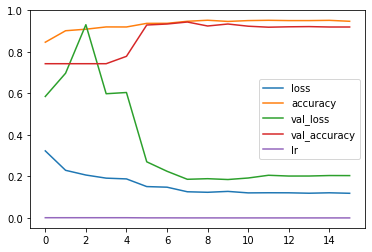

In [56]:
pd.DataFrame(r.history).plot()

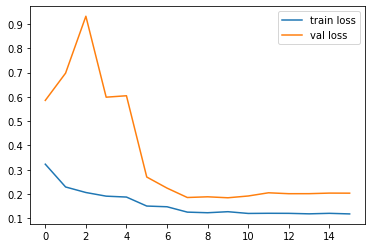

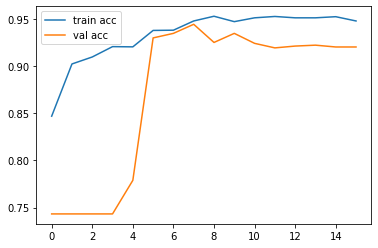

<Figure size 432x288 with 0 Axes>

In [51]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [57]:
preds = cnn.predict(test,verbose=1)

20/20 [==============================] - 7s 318ms/step


In [58]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

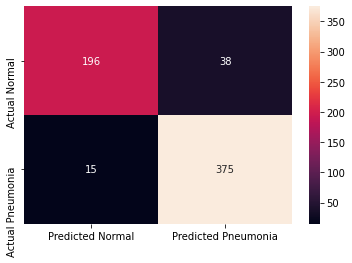

In [59]:
from sklearn.metrics import classification_report,confusion_matrix

cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),
                  index=["Actual Normal", "Actual Pneumonia"],
                  columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [60]:
 print(classification_report(y_true=test.classes, y_pred=predictions,
                            target_names =['NORMAL','PNEUMONIA']
 ))

              precision    recall  f1-score   support

      NORMAL       0.93      0.84      0.88       234
   PNEUMONIA       0.91      0.96      0.93       390

    accuracy                           0.92       624
   macro avg       0.92      0.90      0.91       624
weighted avg       0.92      0.92      0.91       624

